<a href="https://colab.research.google.com/github/untold02/Moving-Object-Direction-Tracking-using-deepSORT/blob/main/cnn_with_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
#the output of torchvision datasets are PILImage of range[0,1]. Transforming them to Tensors of normalized range [-1,1]
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize ((0.5,0.5,0.5), (0.5,0.5,0.5))])

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root= "./data", train =True, download = True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size, shuffle = True, num_workers=2)

100%|██████████| 170498071/170498071 [00:09<00:00, 18907162.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
testset = torchvision.datasets.CIFAR10(root="./data", train = False, download = True, transform=transform)
testloader =torch.utils.data.DataLoader(testset,batch_size = batch_size, shuffle = False, num_workers = 2)
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "ship", "truck")

Files already downloaded and verified


In [ ]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

car  truckdog  frog 


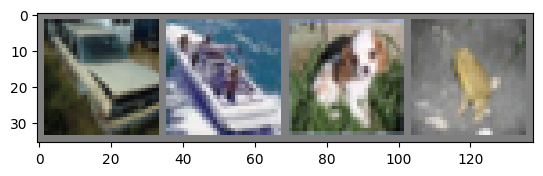

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/ 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show

#get some random training images

dataiter = iter(trainloader)
images, labels = next(dataiter)

#show image
imshow(torchvision.utils.make_grid(images))

#print labels
print(''.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


Define a Convolutional Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5) # 3= color channel, 6 = filter, 5 = 5*5 filter size
        self.pool = nn.MaxPool2d(2,2)  # mqx-pooling layer with 2*2 kernel size(filter size)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1= nn.Linear(16*5*5,120) #this defines fully connected dense layer with 120 output.
                                        #the input size is calculated as the flattened output of the previous convolutional layer, which is 16 channels of 5*5 spatial dimensions.
        self.fc2= nn.Linear(120,84) # 120 as input, 84 as output of the dense layer
        self.fc3 = nn.Linear(84,10) # the final fully connected layer with 10 output neurons

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1) #flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

net = Net()

Defining a loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)


trining the network

In [ ]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get the inputs: data is a lis of  [inputs, labels]
        inputs, labels = data

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: #print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.164
[1,  4000] loss: 1.828
[1,  6000] loss: 1.670
[1,  8000] loss: 1.547
[1, 10000] loss: 1.510
[1, 12000] loss: 1.459
[2,  2000] loss: 1.393
[2,  4000] loss: 1.357
[2,  6000] loss: 1.307
[2,  8000] loss: 1.306
[2, 10000] loss: 1.291
[2, 12000] loss: 1.282
[3,  2000] loss: 1.193
[3,  4000] loss: 1.203
[3,  6000] loss: 1.188
[3,  8000] loss: 1.168
[3, 10000] loss: 1.171
[3, 12000] loss: 1.147
[4,  2000] loss: 1.080
[4,  4000] loss: 1.097
[4,  6000] loss: 1.103
[4,  8000] loss: 1.093
[4, 10000] loss: 1.075
[4, 12000] loss: 1.098
[5,  2000] loss: 1.010
[5,  4000] loss: 0.997
[5,  6000] loss: 1.022
[5,  8000] loss: 1.016
[5, 10000] loss: 1.037
[5, 12000] loss: 1.032
[6,  2000] loss: 0.931
[6,  4000] loss: 0.949
[6,  6000] loss: 0.958
[6,  8000] loss: 0.973
[6, 10000] loss: 0.995
[6, 12000] loss: 0.971
[7,  2000] loss: 0.886
[7,  4000] loss: 0.893
[7,  6000] loss: 0.906
[7,  8000] loss: 0.941
[7, 10000] loss: 0.944
[7, 12000] loss: 0.941
[8,  2000] loss: 0.833
[8,  4000] 

Saving the model

In [ ]:
path = "./cifar_net.pth"
torch.save(net.state_dict(), path)

testing the network on the test data


GroundTruth:  cat   truck truck plane


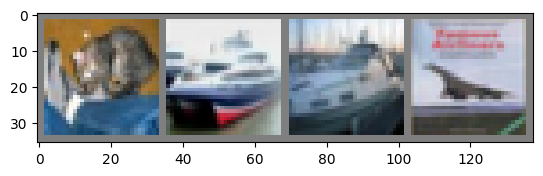

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

#print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: " , ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
outputs = net(images)

In [ ]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 9 %


In [ ]:
import numpy as np
from PIL import Image
import torchvision.transforms as transformss
#loading the trained model
net = Net()
#net.load_state.dict(torch.load("./cifar_net.pth"))
net.eval()

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to the input size of your model
    transforms.ToTensor(),        # Convert to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])
# Load and preprocess the input image
input_image_path = '/content/dog3.jpg'  # Replace with the path to your input image
input_image = Image.open(input_image_path)
input_array = transform(input_image).unsqueeze(0)

# Make predictions
with torch.no_grad():
    class_probabilities = net(input_array)
    _, predicted_class = torch.max(class_probabilities, 1)

# Print the predicted class and class probabilities
print("Predicted Class:", predicted_class.item())
#print("Class Probabilities:", class_probabilities)


Predicted Class: 1


In [ ]:
pip install grad-cam

In [ ]:
from pytorch_grad_cam import GradCAM
#from pytorch_grad_cam import GradCAMPlusPlus

from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

In [ ]:
import os
import torchvision.transforms as transforms

def main():
    #load the model
    model = Net()
    net.eval()
    target_layers = [model.conv2]

    image_path = "/content/dog3.jpg"

    rgb_image = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_image = cv2.resize(rgb_image, (32,32))      # we need to convert out costume image data to the size of the traing dataset(cifar10),i.e 32*32
    rgb_image= np.float32(rgb_image)/255
    #print(rgb_image)

    input_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])(rgb_image).unsqueeze(0)

    # Apply transformations to the image
    i#nput_tensor = image_transforms(rgb_image)
    #input_tensor = input_tensor.unsqueeze(0)
    print(input_tensor)


    targets = [ClassifierOutputTarget(162)]

    cam = GradCAM(model=model, target_layers=target_layers)

    grayscale_cam = cam( input_tensor)
    grayscale_cam = grayscale_cam[0, :]



    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    visualization_np =np.array(visualization)

    #saving the output

    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok= True)
    output_path = os.path.join(output_dir, 'visualization.jpg')
    cv2.imwrite(output_path, cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR ))

if __name__ == "__main__":
    main()


tensor([[[[-2.0665, -1.8097, -2.0837,  ..., -1.4672, -1.6213, -1.6213],
          [-1.9295, -1.9124, -2.0665,  ..., -1.9638, -1.8610, -1.9467],
          [-1.7412, -1.4500, -2.0323,  ..., -1.7240, -1.5870, -1.8268],
          ...,
          [ 0.5707,  0.6049,  0.7248,  ...,  0.4851,  0.2796,  0.5193],
          [ 0.5022,  0.6221,  0.6221,  ...,  0.6563,  0.6906,  0.5536],
          [ 0.4337,  0.5193,  0.5536,  ...,  0.2282,  0.3138,  0.3309]],

         [[-1.9482, -1.6856, -1.8782,  ..., -1.1078, -1.2479, -1.1954],
          [-1.7381, -1.7206, -1.8606,  ..., -1.6681, -1.5455, -1.6681],
          [-1.4405, -1.1604, -1.8256,  ..., -1.3529, -1.0203, -1.5455],
          ...,
          [ 0.2227,  0.2752,  0.3803,  ...,  0.1527, -0.0574,  0.2052],
          [ 0.1702,  0.2927,  0.2752,  ...,  0.3277,  0.3627,  0.2227],
          [ 0.1001,  0.1877,  0.2227,  ...,  0.0301,  0.1176,  0.1176]],

         [[-1.7696, -1.5081, -1.7870,  ..., -1.4384, -1.4384, -1.1770],
          [-1.5779, -1.5604, -